In [20]:
import os
import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import accuracy_score
import warnings
from PIL import Image
warnings.filterwarnings('ignore')

In [21]:
train_directory='C:\\Users\\User\\chest_xray\\train'
val_directory='C:\\Users\\User\\chest_xray\\val'
test_directory='C:\\Users\\User\\chest_xray\\test'


Text(0.5, 1.0, 'Pneumonia')

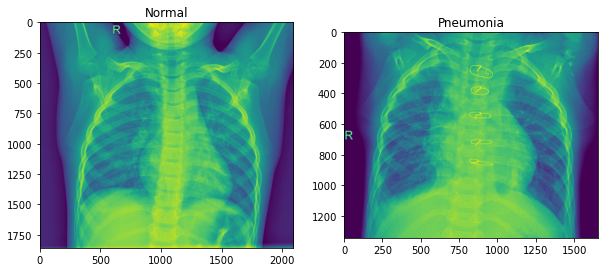

In [22]:
# Load the images & plot a couple of them
norm_load = Image.open('train/NORMAL/IM-0115-0001.jpeg')
sick_load = Image.open('train/PNEUMONIA/person3_bacteria_12.jpeg')

#Let's plt these images
f = plt.figure(figsize= (10,6))
a1 = f.add_subplot(1,2,1)
img_plot = plt.imshow(norm_load)
a1.set_title('Normal')

a2 = f.add_subplot(1, 2, 2)
img_plot = plt.imshow(sick_load)
a2.set_title('Pneumonia')


In [26]:
# Use image generator to normalize/rescale the images
image_generator = ImageDataGenerator(rescale = 1./255)
image_generator_data_aug = ImageDataGenerator(rescale = 1./255,
                                   featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)

In [27]:
train_generator = image_generator_data_aug.flow_from_directory(batch_size = 40, directory= train_directory, shuffle= True, target_size=(64,64), class_mode = 'categorical')


Found 5232 images belonging to 2 classes.


In [28]:
val_generator = image_generator.flow_from_directory(batch_size = 40, directory= val_directory, shuffle= True, target_size=(64,64), class_mode = 'categorical')


Found 16 images belonging to 2 classes.


In [29]:
test_generator = image_generator.flow_from_directory(batch_size = 40, directory= test_directory, shuffle= True, target_size=(64,64), class_mode = 'categorical')


Found 624 images belonging to 2 classes.


In [30]:
# Generate a batch of 40 images and labels
train_images, train_labels = next(train_generator)

In [31]:
#40 images of 256x256 coloured pictures
train_images.shape

(40, 64, 64, 3)

In [32]:
#array of binary result, either has pneumonia or not
train_labels.shape

(40, 2)

In [33]:
labels={0:'Healthy',1:'Pneumonia'}

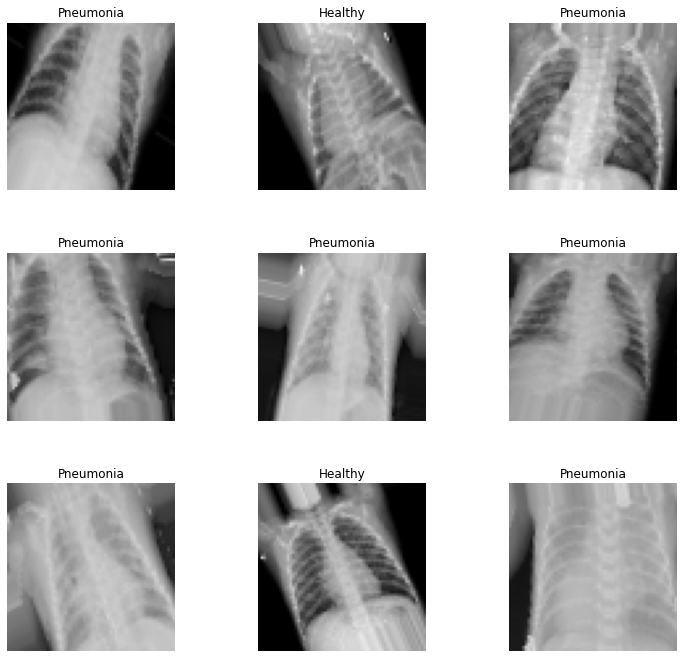

In [34]:
# Create a grid of 9 images along with their corresponding labels
L = 3
W = 3

fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(train_images[i])
    axes[i].set_title(labels[np.argmax(train_labels[i])])
    axes[i].axis('off')

plt.subplots_adjust(wspace = 0.5)    

In [35]:
# Initialising the CNN
cnn = tf.keras.Sequential()

# Step 1 - Convolution
cnn.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), activation = 'relu'))

# Step 2 - Pooling
cnn.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a second convolutional layer
cnn.add(Conv2D(32, (3, 3), activation = 'relu'))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

# Step 3 - Flattening
cnn.add(Flatten())

# Step 4 - Full connection
cnn.add(Dense(units = 128, activation = 'relu'))
cnn.add(Dense(units = 2, activation = 'sigmoid'))

# Compiling the CNN
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [36]:
history = cnn.fit_generator(train_generator, steps_per_epoch= train_generator.n // 4, epochs = 5, validation_data= val_generator, validation_steps= val_generator.n // 4)#, callbacks=[checkpointer, earlystopping])

Epoch 1/5
1308/1308 [==============================] - 1004s 768ms/step - loss: 0.2749 - acc: 0.8817 - val_loss: 0.6772 - val_acc: 0.6875
Epoch 2/5
1308/1308 [==============================] - 861s 658ms/step - loss: 0.1745 - acc: 0.9317 - val_loss: 0.5172 - val_acc: 0.7500
Epoch 3/5
1308/1308 [==============================] - 861s 659ms/step - loss: 0.1483 - acc: 0.9422 - val_loss: 0.3755 - val_acc: 0.8438
Epoch 4/5
1308/1308 [==============================] - 877s 670ms/step - loss: 0.1415 - acc: 0.9458 - val_loss: 0.5783 - val_acc: 0.7812
Epoch 5/5
1308/1308 [==============================] - 850s 650ms/step - loss: 0.1299 - acc: 0.9504 - val_loss: 0.3234 - val_acc: 0.8125


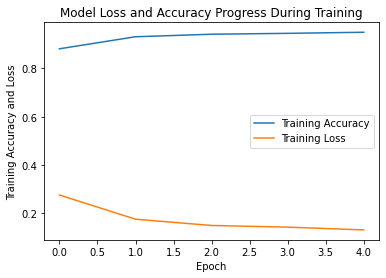

In [37]:
plt.plot(history.history['acc'])
plt.plot(history.history['loss'])

plt.title('Model Loss and Accuracy Progress During Training')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy and Loss')
plt.legend(['Training Accuracy', 'Training Loss'])

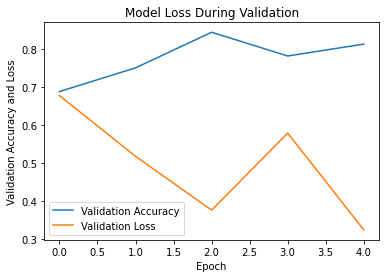

In [41]:
plt.plot(history.history['val_acc'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss During Validation')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy and Loss')
plt.legend(['Validation Accuracy','Validation Loss'])

In [39]:
test_accu = cnn.evaluate_generator(test_generator,steps=624)

In [40]:
print('The testing accuracy is :',round(test_accu[1]*100,2), '%')

The testing accuracy is : 90.46 %


## Use Pretrained Model

In [42]:
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(64,64,3)))

In [43]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [44]:
# freezing layers in the model (except the last ten)
for layer in basemodel.layers[:-10]:
    layers.trainable = False

In [45]:
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (2,2))(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel) #for generalizing 
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(2, activation = 'softmax')(headmodel) #last layer has number of neurons according to problems nature

model = Model(inputs = basemodel.input, outputs = headmodel)

In [46]:
model.compile(loss = 'categorical_crossentropy', optimizer=optimizers.RMSprop(lr = 1e-4, decay = 1e-6), metrics= ["accuracy"])

In [47]:
# using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="weights.hdf5", verbose=1, save_best_only=True)

In [48]:
history = model.fit_generator(train_generator, steps_per_epoch= train_generator.n // 4, epochs = 5, validation_data= val_generator, validation_steps= val_generator.n // 4, callbacks=[checkpointer, earlystopping])

Epoch 1/5
   4/1308 [..............................] - ETA: 27:09 - loss: 1.1727 - acc: 0.8125
Epoch 00001: val_loss improved from inf to 1.17272, saving model to weights.hdf5
1308/1308 [==============================] - 3892s 3s/step - loss: 0.1330 - acc: 0.9523 - val_loss: 1.1727 - val_acc: 0.8125
Epoch 2/5
   4/1308 [..............................] - ETA: 9:59 - loss: 0.6556 - acc: 0.8125 
Epoch 00002: val_loss improved from 1.17272 to 0.65561, saving model to weights.hdf5
1308/1308 [==============================] - 3635s 3s/step - loss: 0.0758 - acc: 0.9753 - val_loss: 0.6556 - val_acc: 0.8125
Epoch 3/5
   4/1308 [..............................] - ETA: 10:10 - loss: 1.6691 - acc: 0.7500
Epoch 00003: val_loss did not improve from 0.65561
1308/1308 [==============================] - 3672s 3s/step - loss: 0.0665 - acc: 0.9790 - val_loss: 1.6691 - val_acc: 0.7500
Epoch 4/5
   4/1308 [..............................] - ETA: 11:02 - loss: 26.9646 - acc: 0.6250
Epoch 00004: val_loss did n

In [49]:
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

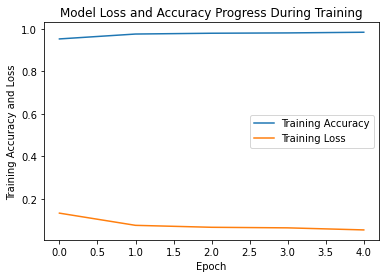

In [50]:
plt.plot(history.history['acc'])
plt.plot(history.history['loss'])

plt.title('Model Loss and Accuracy Progress During Training')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy and Loss')
plt.legend(['Training Accuracy', 'Training Loss'])

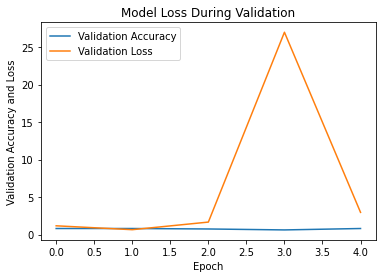

In [51]:
plt.plot(history.history['val_acc'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss During Validation')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy and Loss')
plt.legend(['Validation Accuracy','Validation Loss'])

In [52]:
test_accu =model.evaluate_generator(test_generator,steps=624)

In [53]:
print('The testing accuracy is :',round(test_accu[1]*100,2), '%')

The testing accuracy is : 86.06 %
